In [106]:
# basic libraries import
import os
import glob
import sys
import pandas as pd
import numpy as np

#reading data
import json

# Plotting libraries and parameters
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', facecolor = 'white')
matplotlib.rc('axes', grid = False)
matplotlib.rc('font', size = 14)
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers


In [107]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/Fit_Finder/

In [108]:
BASE_PATH = "../Data/"
BASE_MODEL_PATH = "../Model/"

In [109]:
df = pd.read_csv(BASE_PATH+"processed_data.csv")

In [110]:
df.head()

,Unnamed: 0,item_id,size,quality,cup_size,hips,bra_size,category,height,user_name,length,fit,review_text
0,0,123373,7,5.0,d,M,34.0,new,167.64,emily,just right,small,Unknown
1,1,123373,13,3.0,b,XS,36.0,new,157.48,sydneybraden2001,just right,small,Unknown
2,2,123373,7,2.0,b,Unknown,32.0,new,170.18,ugggh,slightly long,small,Unknown
3,3,123373,21,5.0,dd/e,Unknown,36.0,new,165.10,alexmeyer626,just right,fit,Unknown
4,4,123373,18,5.0,b,Unknown,36.0,new,157.48,dberrones1,slightly long,small,Unknown


In [111]:
df = df.drop("Unnamed: 0",axis =1)

In [112]:
df.head()


,item_id,size,quality,cup_size,hips,bra_size,category,height,user_name,length,fit,review_text
0,123373,7,5.0,d,M,34.0,new,167.64,emily,just right,small,Unknown
1,123373,13,3.0,b,XS,36.0,new,157.48,sydneybraden2001,just right,small,Unknown
2,123373,7,2.0,b,Unknown,32.0,new,170.18,ugggh,slightly long,small,Unknown
3,123373,21,5.0,dd/e,Unknown,36.0,new,165.10,alexmeyer626,just right,fit,Unknown
4,123373,18,5.0,b,Unknown,36.0,new,157.48,dberrones1,slightly long,small,Unknown


In [113]:
# Split into train and validation dataset, i am not showing any performance on 
# test dataset for now,
df  = df.drop("review_text",axis=1)
train, val = train_test_split(df, test_size=0.2)

In [114]:
user_categorical_features = ["user_name","hips","cup_size"]
user_numerical_features = ["height","bra_size"]
item_categorical_features = ["item_id", "category", "length"]
item_numerical_features = ["size","quality"]

In [115]:
# Scaling the numerical features
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(train[["height","bra_size","size","quality"]])

In [116]:
train[["height","bra_size","size","quality"]] = scaler.transform(train[["height","bra_size","size","quality"]])
val[["height","bra_size","size","quality"]] = scaler.transform(val[["height","bra_size","size","quality"]])

c:\users\int004889\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
c:\users\int004889\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [117]:
for col in user_categorical_features + item_categorical_features:
  df[col] = df[col].astype(str)

In [118]:
# 1) Create feature columns for ingestion into NN

# Numeric Columns
numeric_users = {
    col : feature_column.numeric_column(col) \
          for col in user_numerical_features
}
numeric_items = {
    col : feature_column.numeric_column(col) \
          for col in item_numerical_features
}

# Categorical Columns
# Now categorical columns can be encoded into one-hot vectors and fed into NN
# But the paper has used embedding and hence we can use the same (generally used for
# a categroical feature with lots of categories, but let us see)

hips = feature_column.categorical_column_with_vocabulary_list(
      'hips', df.hips.unique().tolist())
cup_size = feature_column.categorical_column_with_vocabulary_list(
      'cup_size', df.cup_size.unique().tolist())
user_name = feature_column.categorical_column_with_vocabulary_list(
      'user_name', df.user_name.unique().tolist())



item_id = feature_column.categorical_column_with_vocabulary_list(
      'item_id', df.item_id.unique().tolist())
category = feature_column.categorical_column_with_vocabulary_list(
      'category', df.category.unique().tolist())
length = feature_column.categorical_column_with_vocabulary_list(
      'length', df.length.unique().tolist())

# There are 6 dimension hyperparameters to be given here which is a lot,
# hence for now i am giving these values, later we will see if we can
# somehow guide the decision via cross-val
hips_embedding = feature_column.embedding_column(hips, dimension=5)
cup_size_embedding = feature_column.embedding_column(cup_size, dimension=5)
user_name_embedding = feature_column.embedding_column(user_name, dimension=50)
item_id_embedding = feature_column.embedding_column(item_id, dimension=50)
category_embedding = feature_column.embedding_column(category, dimension=5)
length_embedding = feature_column.embedding_column(length, dimension=5)

cat_users = {
    'hips' : hips_embedding,
    'cup_size' : cup_size_embedding,
    'user_name': user_name_embedding
}

cat_items = {
    'item_id' : item_id_embedding,
    'category' : category_embedding,
    'length': length_embedding
}

input_user = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in numeric_users.keys()
}
input_user.update({
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in cat_users.keys()
})

input_items = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype = 'float32') \
          for colname in numeric_items.keys()
}

input_items.update({
    colname : tf.keras.layers.Input(name=colname, shape=(),  dtype='string') \
          for colname in cat_items.keys()
})

In [119]:
# Create a feature layer
feature_layer_users = keras.layers.DenseFeatures(numeric_users.values())(input_user)
feature_layer_items = keras.layers.DenseFeatures(numeric_items.values())(input_items)

In [120]:
CLASS_LABELS =  np.array(["fit","small","large"])


In [121]:
# 2) Create a input pipeline using tf.data
# A utility method to create a tf.data dataset from a Pandas Dataframe
import copy
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('fit')
  labels = labels.apply(lambda x:x == CLASS_LABELS)
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  #prefetching was giving some trouble on google colab,
  #there might be some issue with some gdfs, hence not here
  return ds

In [122]:
class SkipCon(keras.layers.Layer):
  def __init__(self, size, reduce = True, deep = 3, skip_when=0, activation="relu", **kwargs):
    """
    @Params
    size = size of dense layer
    deep = the depth of network in one SkipCon block call
    skip_when =  if a skip connection is required, pass 1
    activation = by default using relu, in the paper authors have used tanh(no reasons again)
    """    
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # used to combine
    # skip connections and cascaded dense layers
    self.main_layers =[]
    self.skip_when = skip_when #to be used in call as a control
    if reduce:
      for _ in range(deep):
        self.main_layers.extend([
          keras.layers.Dense(size, activation=activation, 
                              use_bias=True),
          keras.layers.BatchNormalization()])

        # Reduce the input size by two each time, if the
        # network is to be designed deeper and narrow
        size = size/2
    else:
      for _ in range(deep):
        self.main_layers.extend([
        keras.layers.Dense(size, activation=activation, 
                            use_bias=True),
        keras.layers.BatchNormalization()])
        
    self.skip_layers = []
    if skip_when > 0:
      if reduce:
        size = size*2 # since the size of skipped connection  
                      # should match with cascaded dense
      self.skip_layers = [
          keras.layers.Dense(size, activation=activation, 
                          use_bias=True),
          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    if not self.skip_when:
      return self.activation(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [123]:
batch_size = 512 # paper they have taken 2048 batch size, but no clear explanation
# tanh activation is used, but i am using relu
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [124]:
user_layer = keras.layers.Dense(256, activation='relu', use_bias = True)(feature_layer_users)
# Add a Skip Connection
user_layer = SkipCon(size = 256, deep = 2, reduce = False, skip_when=1, activation="relu")(user_layer)
user_layer = keras.layers.Dropout(0.5)(user_layer) # Way to handle overfitting
user_layer = SkipCon(size = 256, deep = 2, reduce = True, skip_when=1, activation="relu")(user_layer)
user_layer = keras.layers.Dropout(0.5)(user_layer)
user_layer = SkipCon(size = 64, deep = 2, reduce = True, skip_when=0, activation="relu")(user_layer)


item_layer = keras.layers.Dense(256, activation='relu', use_bias = True)(feature_layer_items)
# Add a Skip Connection
item_layer = SkipCon(size = 256, deep = 2, reduce = False, skip_when=1, activation="relu")(item_layer)
item_layer = keras.layers.Dropout(0.5)(item_layer) # Way to handle overfitting
item_layer = SkipCon(size = 256, deep = 2, reduce = True, skip_when=1, activation="relu")(item_layer)
item_layer = keras.layers.Dropout(0.5)(item_layer)
item_layer = SkipCon(size = 64, deep = 2, reduce = True, skip_when=0, activation="relu")(item_layer)


# combine the output of the two branches
combined = tf.concat([user_layer, item_layer], axis =-1)

# The combined input should go through another set of skip connection non-linearity as per the paper
both_layer = SkipCon(size = 128, deep = 2, reduce = False, skip_when=1, activation="relu")(combined)
both_layer = keras.layers.Dropout(0.5)(both_layer)
both_layer = SkipCon(size = 64, deep = 2, reduce = False, skip_when=1, activation="relu")(combined)
both_layer = keras.layers.Dropout(0.5)(both_layer)
both_layer = SkipCon(size = 16, deep = 2, reduce = False, skip_when=0, activation="relu")(both_layer)

z = keras.layers.Dense(3, activation="softmax")(both_layer)

model = keras.Model(inputs=[input_user, input_items], outputs=z)

In [125]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bra_size (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
cup_size (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
height (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
hips (InputLayer)               [(None,)]            0                                            
____________________________________________________________________________________________

In [128]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

# Another control put in place to handle overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',verbose=1,patience=10,mode='max',restore_best_weights=True)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "../Model/checkpoints/"
os.makedirs(checkpoint_path + datetime.datetime.now().strftime("%Y%m%d-%H%M"))
cpt_folder = checkpoint_path + datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = cpt_folder + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every epochs
cp_callback = ModelCheckpoint(checkpoint_dir,verbose=1,mode='max', save_weights_only=True)

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)



# Metrics for each epoch
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.01)

model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=METRICS,
              callbacks = [early_stopping,cp_callback])

In [129]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=15)

Epoch 1/15
112/112 [==============================] - 47s 423ms/step - loss: 0.8420 - tp: 38519.0000 - fp: 16580.0000 - tn: 97436.0000 - fn: 18489.0000 - accuracy: 0.7949 - precision: 0.6991 - recall: 0.6757 - auc: 0.7861 - val_loss: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/15
112/112 [==============================] - 33s 293ms/step - loss: 0.8068 - tp: 39762.0000 - fp: 16717.0000 - tn: 97299.0000 - fn: 17246.0000 - accuracy: 0.8014 - precision: 0.7040 - recall: 0.6975 - auc: 0.8019 - val_loss: 0.8160 - val_tp: 9966.0000 - val_fp: 4286.0000 - val_tn: 24218.0000 - val_fn: 4286.0000 - val_accuracy: 0.7995 - val_precision: 0.6993 - val_recall: 0.6993 - val_auc: 0.7938
Epoch 3/15
112/112 [==============================] - 35s 315ms/step - loss: 0.8033 - tp: 39683.0000 - fp: 16676.0000 - tn: 97340.0000 - fn: 17325.0000 - accurac

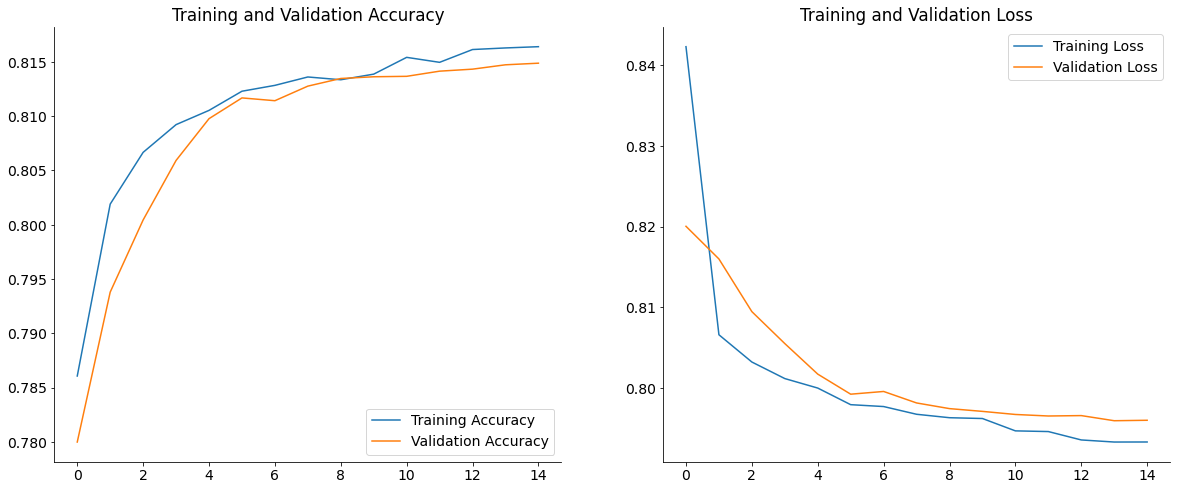

In [130]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training Accuracy')
plt.plot(epochs_range, val_auc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()